## Проект спринт 11
**Название проекта**:  
ГлавРосГосНефть   
_____
**Описание исследования**:  
Имеются пробы нефти в трёх регионах. Необходимо построить модель для прогноза возможной прибыли и рисков  
_____
**Цель исследования**:  
Определение региона, где добыча принесёт наибольшую прибыль.
_____
**План исследования.**  
[Шаг 1. Загрузка и подготовка данных](#step1)  
[Шаг 2. Обучение и проверка модели для каждого региона](#step2)  
[Шаг 3. Подготовка к расчёту прибыли](#step3)  
[Шаг 4. Расчёт прибыли по выбранным скважинам и предсказаниям модели](#step4)  
[Шаг 5. Расчет рисков и прибыли для каждого региона](#step5)  
[Шаг 6. Результаты и выводы](#step6)  
_____
**Исходные данные.**
Исходные файлы, содержащие данные геологоразведки трёх регионов:  
- <a HREF='geo_data_0.csv'>geo_data_0.csv</a>  
- <a HREF='geo_data_1.csv'>geo_data_1.csv</a>  
- <a HREF='geo_data_2.csv'>geo_data_2.csv</a>  
Поля файлов:
- id — уникальный идентификатор скважины
- f0, f1, f2 — три неизвестных, но значимых признака точек
- product — объём запасов в скважине (тыс. баррелей)

## Шаг 1. Загрузка и подготовка данных

In [43]:
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
RANDOM_STATE = 54321
pd.options.mode.chained_assignment = None


In [3]:
try:
    df = pd.read_csv('geo_data_0.csv')
    print('Загрузили файл локально')
except:
    print('локально не удалось, загружаем из интернета')
    df = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')

Загрузили файл локально


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
df.sample(10)

,id,f0,f1,f2,product
26521,qB6h6,1.660441,-0.212713,6.182273,76.925749
69913,oYd69,0.634352,0.773178,4.593667,88.663533
62532,6c0cR,1.978894,0.266864,3.468192,144.858705
79992,RlAWo,-0.742142,0.648475,4.750650,129.141831
82426,qNJ0M,0.042194,0.572153,-1.637191,163.952183
9607,n9DEz,0.409701,-0.237292,-2.748229,109.018090
9470,2Mb9b,0.469172,0.795167,-2.990324,132.644436
86385,66EnH,0.537400,0.928757,2.966905,64.629560
50993,U5CJM,1.083731,0.096286,8.109514,129.330646
89798,5cJGH,0.602935,0.834459,9.627986,134.636444


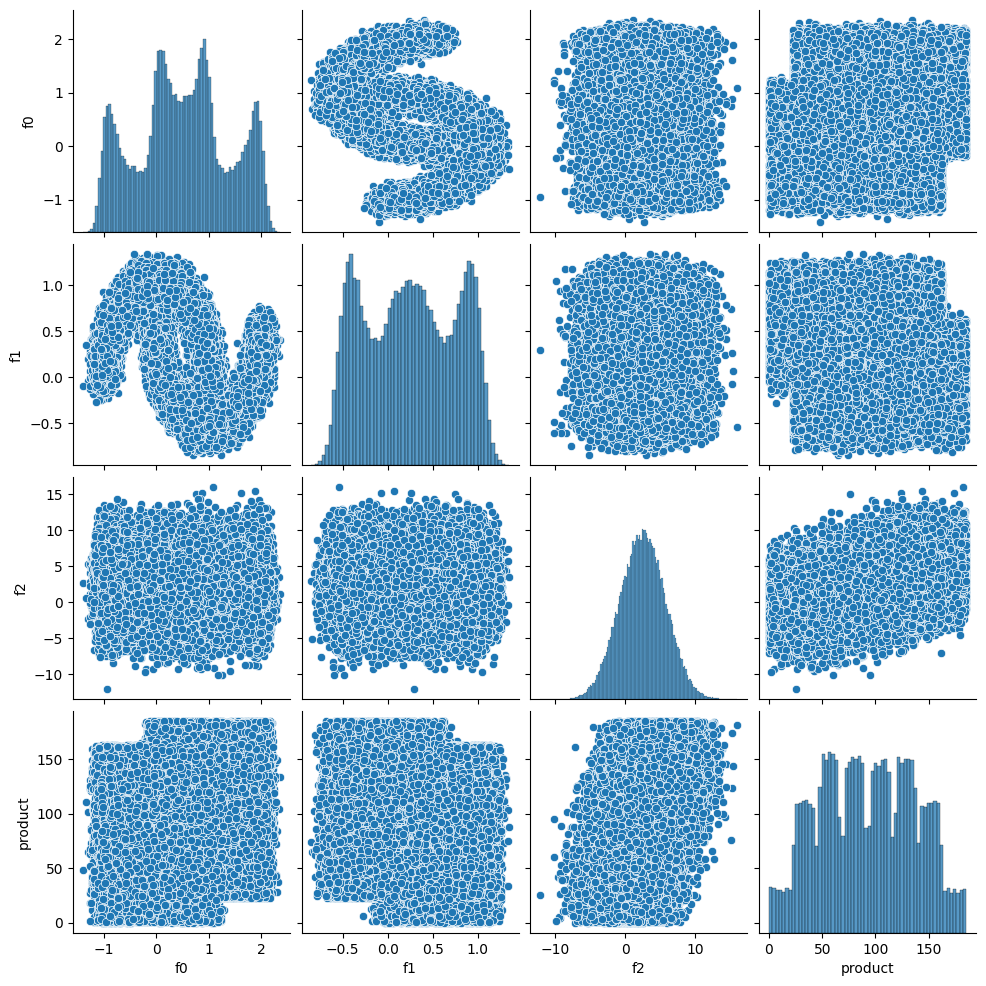

In [9]:
sns.pairplot(df)

In [46]:
def process_file(file_name):
    try:
        df = pd.read_csv(file_name)
        print('Загрузили файл локально')
    except:
        print('локально не удалось, загружаем из интернета')
        df = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
#    display(df.info())
    df.drop('id', axis='columns', inplace=True)
#    display(df.info())
    features = df.drop('product', axis='columns')
    target = df['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=RANDOM_STATE)
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train.loc[:,numeric] = scaler.transform(features_train.loc[:,numeric])
    features_valid.loc[:,numeric] = scaler.transform(features_valid.loc[:,numeric])
    model = LinearRegression()
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    print(f'регион: {file_name}\tсредний запас: {predict_valid.mean()}\tRMSE: {mean_squared_error(target_valid, predict_valid, squared=False)}')
    return features_train, features_valid, target_train, target_valid, model, predict_valid

In [47]:
X_train, X_valid, y_train, y_valid, model, predict_valid = process_file('geo_data_0.csv')
X_train, X_valid, y_train, y_valid, model, predict_valid = process_file('geo_data_1.csv')
X_train, X_valid, y_train, y_valid, model, predict_valid = process_file('geo_data_2.csv')


Загрузили файл локально
регион: geo_data_0.csv	средний запас: 92.15921155743655	RMSE: 37.68341093860808
Загрузили файл локально
регион: geo_data_1.csv	средний запас: 68.44594093153303	RMSE: 0.892281970848146
Загрузили файл локально
регион: geo_data_2.csv	средний запас: 94.92229500787452	RMSE: 40.15250541784855


расчет безубыточности.  
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
Бюджет на разработку скважин в регионе — 10 млрд рублей.  
При нынешних ценах один баррель сырья приносит 450 рублей дохода.  
Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
200 * ср.запас * 450.000 - 10.000.000.000 = 0  
ср.запас = 1000 / 9 = 111.11